## Kalman observer

I previously mentioned glitches in position sensing, likely caused by "dead spots" in the TIO (tin indium oxide) layer(s) of the resistive touchscreen. The sudden apparent movement of the ball will cause the controller to react, sometimes causing the ball to fall off the platform. I will be exploring the use of a Kalman observer in the hopes of minimizing the effects of these glitches.

In [1]:
import matplotlib.pyplot as plt   # MATLAB plotting functions
import control
import control.matlab
import numpy as np

In [140]:
# Parameters defining the system

# Augmented system matrices
Aa = np.matrix( [[ 0,  1., 0.],
                 [ 0., 0., 0.], 
                 [ 1., 0., 0.]] )
Ba =  np.matrix( [[ 0.],
                [   350.],
                 [  0.]] )
Br = np.matrix( [[ 0.],
                [  0.],
                [  -1.]] )
Ca =  np.matrix( [[1., 0., 0.]] )

Tstep = 0.1

## compute feedback system
poles = [-2.2, -2., -1.8] ## [-5, -4.4, -4.2]
Kfeedback = control.place(Aa, Ba, poles)
feedbackA = Aa - Ba@Kfeedback  ## augmented closed loop A matrix computed with Ba

### system matrices from original system measurement
A = np.matrix( [[0, 1.],
                [0, 0]] )
B =  np.matrix( [[0],
                [350.]] )
C =  np.matrix( [[1., 0]] )

### and make a discrete version so it can be calculated step by step for simulation
sys = control.ss(A,B,C,0)
sysd = control.matlab.c2d(sys, Tstep)

## Kalman observer/filter

In [161]:
Vd = np.matrix([    [3, 0],     ## This is the state noise covariance matrix
                    [0, 3]])
Vn = 10                         ## This is the sensor noise covariance

Kobs,P,E = control.lqe(A, Vd, C, Vd, Vn)

print("Kalman gain matrix:")
print(Kobs) ## gain for Kalman observer
# print(P)
print("\nEigenvalues:")
print(E)    ## eigenvalues for observer

kalmanObs = control.ss(A - Kobs @ sys.C, np.concatenate( (B, Kobs), axis=1), np.eye(2), 0 )

### now make discrete time so we can compute system state recursively
kalmanObsd = control.matlab.c2d(kalmanObs,Tstep)
print("Kalman matrices:\n",kalmanObsd)


Kalman gain matrix:
[[2.44669887]
 [1.64316767]]

Eigenvalues:
[[-1.22334945 -1.22334945]]
Kalman matrices:
 A = [[ 0.77598163  0.08846358]
 [-0.14536049  0.99242537]]

B = [[ 1.61342132  0.22401837]
 [34.90980857  0.14536049]]

C = [[1. 0.]
 [0. 1.]]

D = [[0. 0.]
 [0. 0.]]

dt = 0.1



## Manual simulation of integrator
In preparation of translating to Arduino, do manual computation of augmented system.

Get a "measured" X position. In the simulation, we will "measure" the position from the "real" system and add a little noise. With this measured position and last control input, u, use the observer to compute an estimated state, xhat.

This xhat is then used to update sigma, the new variable that is an integral of the error signal, (estimated position - desired position) * Tstep. Since the real system, i.e. ball and platform, doesn't have a sigma, we will need to calculate and keep track of this manually. It is then concatenated to xhat prior to multiplying by the augmented feedback matrix, Kfeedback, which now is size 1x3.

N.B. The only thing that is augmented here is the new Kfeedback. The observer and "real" system are still both rank 2. As such, when doing the feedback calculation, u = -K*x, you need to concatenate sigma to the state variable containing only position and velocity.

In [162]:
def doKalmanSim(kalmanGain, noise): ## parameters are Kalman gain and noise
    ### make kalman system using kalmain gain
    kalmanObs = control.ss(A - kalmanGain @ sys.C, np.concatenate( (B, kalmanGain), axis=1), np.eye(2), 0 )
    kalmanObsd = control.matlab.c2d(kalmanObs,Tstep)

    obs_U = np.zeros((2,1))       ## Input to the observer system
    xhat = np.matrix([[0],[0]])   ## set initial xhat value for observer system

    x= np.matrix([[200], [0]])    ## set initial value of x. Mismatched from xhat

    xdesired = np.zeros(250)      ## make array of desired positions. Zero to start.
                                ## This will give time for observer to catch up.
    xdesired[75:150]= 200         ## then a step up then a step down

    xArray = np.matrix([[0], [0], [0]])   ## Arrays of x, xhat, and u to save for plotting
    xhatArray = np.matrix([[0], [0]])
    uArray = np.matrix([0]).reshape(1,1)
    measuredArray = [0]

    sigma = 0                      ## our new state variable.
    u = np.matrix(0)

    for i in range(250):
        measuredX = x[0,0] + np.random.randn() * noise # measure position of real system. Add noise

        if i == 125:
            measuredX = 0.
        obs_U[0,0] = u              ## set up input to observer. Control input
        obs_U[1,0] = measuredX      ## and measured X

        xhat = kalmanObsd.A @ xhat + kalmanObsd.B @ obs_U     ### calculate observer estimate

        xhatArray = np.concatenate((xhatArray, xhat), axis = 1)   ### save xhat, u, and x for plotting
        uArray = np.concatenate((uArray, u), axis = 1)
        measuredArray.append(measuredX)
        xArray = np.concatenate((xArray, np.concatenate( (x, np.matrix(sigma)), axis=0)), axis = 1)

        sigma += (xhat[0,0] - xdesired[i])  * Tstep     ### manually update integrator
        
        u =  -Kfeedback @ np.concatenate((xhat, np.matrix(sigma)), axis=0) ## compute u using Kfeedback
                                                                        ## and augmented x state
        x  = sysd.A @ x + sysd.B @ u ## simulate augmented "real" system

    t = np.arange(len(measuredArray))* Tstep

    plt.figure(figsize=(12,8))

    plt.plot(t,xArray[0,:].T, 'b',label = 'System')
    plt.plot(t,xhatArray[0,:].T, 'r--', label = 'xhat')
    # plt.plot(t,xArray[2,:].T, 'g',label = 'sigma')
    plt.plot(t[:-1], xdesired, 'k-', alpha = 0.3, label='Desired')
    plt.plot(t,measuredArray, 'g.', label= 'Measured')

    plt.xlabel('Time (s)')
    plt.ylabel('X Position (digitizer units)')
    plt.title('Manual Simulation with Integrator');
    plt.legend(loc="top right")

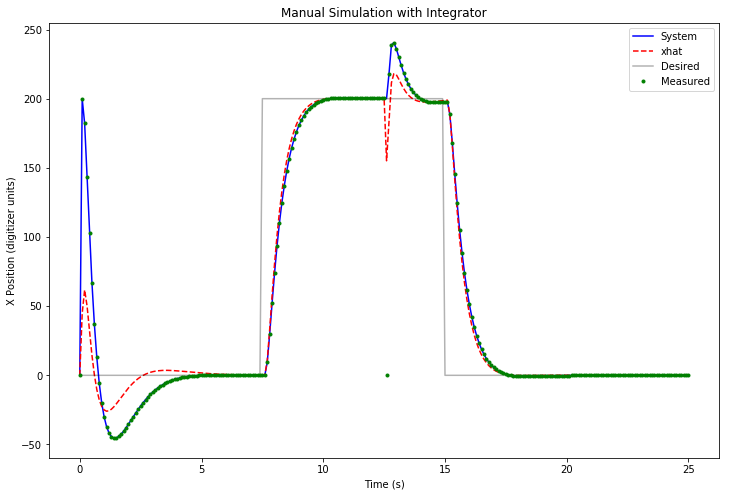

In [163]:
doKalmanSim(Kobs, 0)

## Kalman observer parameter tuning
The Kalman observer seems to be an improvement over the Luenberger observer w.r.t. noise and glitch resistance. You can adjust the parameters of the Kalman to make it more noise resistant. This does come at the cost of slower capture of the true state. The plot below demonsrates the effects of varying the covariance matrices.

Like the previous simulation, there is a step up and a step down. Gaussian noise has been added to the sensor measurement. There is also a sensor glitch near the middle.

The simulation is started with a mismatch between the real and estimated state so the capture kinetics can be seen.

When the sensor noise covariance is increased, the Kalman observer becomes more noise/glitch resistant but takes longer to capture

These are the original Kalman parameters but with noise added to sensor measurements.

The system is captured at 4s and the glitch is around 25%.

Kalman gain: 
 [[2.44669887]
 [1.64316767]] 

Eigenvalues:  [[-1.22334945 -1.22334945]]


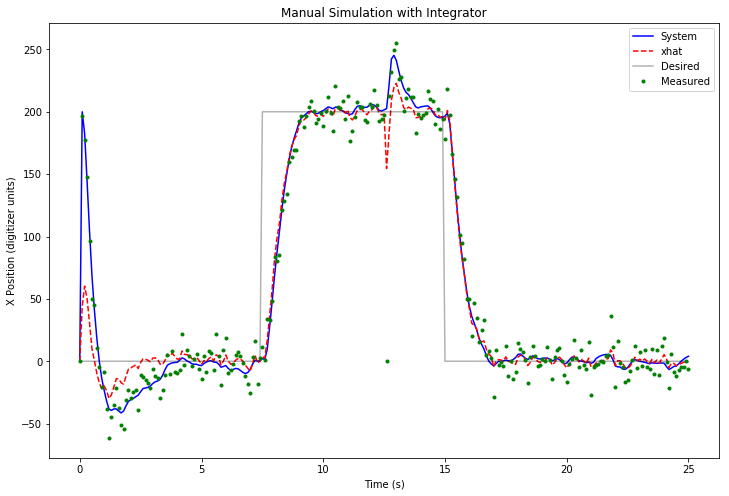

In [164]:
Vd = np.matrix([    [3, 0],     ## This is the state noise covariance matrix
                    [0, 3]])
Vn = 10                         ## This is the sensor noise covariance

Kobs,P,E = control.lqe(A, Vd, C, Vd, Vn)
print("Kalman gain: \n",Kobs, "\n")
print("Eigenvalues: ", E)
doKalmanSim(Kobs, 10) ## add noise of 10*normal_dist

## High measurement noise covariance.
Sensor noise covariance increased to 200. The xhat approximation is now smoother and glitch resistant but takes longer to capture--it now takes over 5 seconds. Not shown here, but if the "real" system dynamics are different from the feedback dynamics, i.e. B and Ba are different, it will take even longer to capture. This is likely true for all situations but more apparent here.

Kalman gain: 
 [[0.93265584]
 [0.36742346]] 

Eigenvalues:  [[-0.46632794 -0.46632794]]


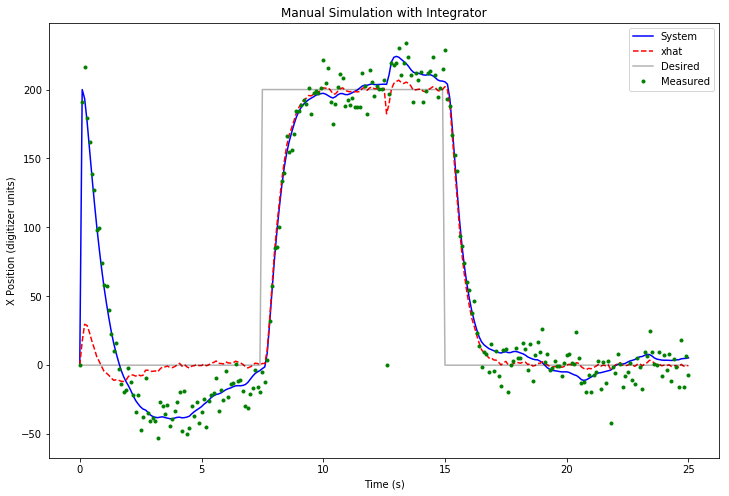

In [165]:
Vd = np.matrix([    [3, 0],     ## This is the state noise covariance matrix
                    [0, 3]])
Vn = 200                         ## This is the sensor noise covariance

Kobs,P,E = control.lqe(A, Vd, C, Vd, Vn)
print("Kalman gain: \n",Kobs, "\n")
print("Eigenvalues: ", E)
doKalmanSim(Kobs,10)

## Low measurement covariance
With a small measurement covariance, the capture is almost quicker but the noise/glitch resistance suffers.

Kalman gain: 
 [[17.40296967]
 [16.43167673]] 

Eigenvalues:  [[-16.40110588  -1.00186396]]


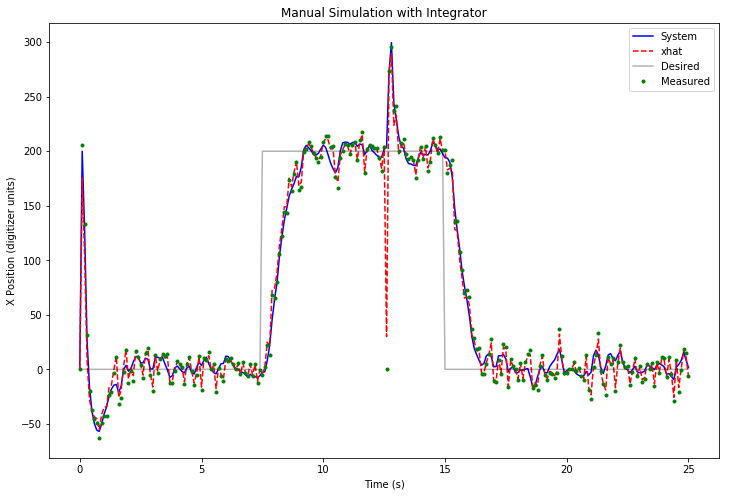

In [166]:
Vd = np.matrix([    [3, 0],     ## This is the state noise covariance matrix
                    [0, 3]])
Vn = .1                         ## This is the sensor noise covariance

Kobs,P,E = control.lqe(A, Vd, C, Vd, Vn)
print("Kalman gain: \n",Kobs, "\n")
print("Eigenvalues: ", E)
doKalmanSim(Kobs,10)

In [ ]:
## Steady state error with Kalman observer
I translated the above to Arduino and to my surprise, there was a huge steady state error! It appears that the Kalman velocity estimation can be large even though the measured and estimated positions are unchanging. Counterintuitive to say the least. The solution was to increase the noise covariance term for velocity--, position 2,2 in the Vd matrix. I picked 20 just for grins and it appears to work well.

Kalman gain: 
 [[ 7.69860653]
 [28.28427125]] 

Eigenvalues:  [[-3.84930325 -3.84930325]]
kalman system:
	matrix A
0.37908378887363425 , 0.06653266336609243 , -1.8818278974632858 , 0.8912925854841883 , 
	matrix B
1.3451856244638154 , 0.6209162111263659 , 33.642487009924565 , 1.8818278974632863 , 

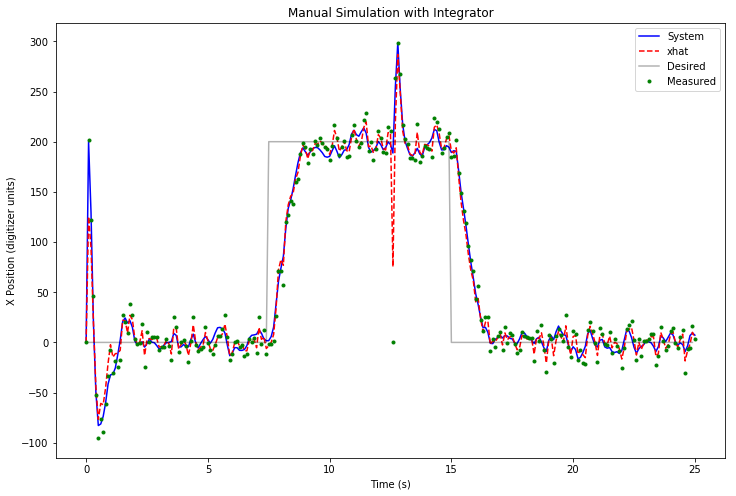

In [186]:
Vd = np.matrix([    [3, 0],     ## This is the state noise covariance matrix
                    [0, 20]])   
Vn = 10                         ## This is the sensor noise covariance

Kobs,P,E = control.lqe(A, Vd, C, Vd, Vn)
print("Kalman gain: \n",Kobs, "\n")
print("Eigenvalues: ", E)
doKalmanSim(Kobs,10)

kalmanObs = control.ss(A - Kobs @ sys.C, np.concatenate( (B, Kobs), axis=1), np.eye(2), 0 )
kalmanObsd = control.matlab.c2d(kalmanObs,Tstep)

print("kalman system:")
print("\tmatrix A")
for i in np.asarray(kalmanObsd.A.flatten()).reshape(-1):
    print(i, ', ', end='')
print("\n\tmatrix B")
for i in np.asarray(kalmanObsd.B.flatten()).reshape(-1):
    print(i, ', ', end='')

I think thats it for now. Maybe I'll try to tackle the linear quadratic regulator (LQR) later.